In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
import spacy
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import nltk

torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim import Adam, SGD
from math import floor
from torch.utils.data import Dataset
from __future__ import division
import math
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numbers
import types
import collections
from torchvision import transforms
from scipy.ndimage import gaussian_filter
import torchvision.models as models
from matplotlib import image
import matplotlib.pyplot as plt
import random
random.seed(9)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip -uq "/content/drive/MyDrive/DL_HW3_Q1/archive.zip" -d "/content"

Note:
 
For doing this homework, I've watched image captioning tutorials from "Alladin Perrson" channel on YouTube.
 
https://www.youtube.com/c/AladdinPersson
 
https://www.youtube.com/watch?v=y2BaTt1fxJU&t=1892s
 
https://www.youtube.com/watch?v=9sHcLvVXsns&t=0s
 
 
The codes I wrote are "not" "copies" of the tutorials,
however, a great deal might seem similiar to the tutorials mentioned...
but I need to mention that almost all other image captioning tutorials found on the internet are quite the same,
So, yeah, I just used the tutorials to help me understand the process.
And I have written about every step in this process in details.

In [ ]:
class Vocabulary:
  def __init__(self,repeated):
    self.num2word={0:'<PAD>',1:'<SOS>',2:'<EOS>',3:'<UNK>'} #this dictionary assigns a word in text to a number
    # PAD is for padding. I will explain about this further in the code.
    # SOS stands for start of sentence #EOS is for end of sentence
    # UNK stands for unknown
    self.word2num={b:a for a,b in self.num2word.items()} #this, does the reverse of the previous dictionary
    self.tokenizer=nltk.RegexpTokenizer(r"\w+") #this is used to tokenize a sentence, in this case it removes all punctuation marks
    self.repeated=repeated #this denotes how many times a word needs to be repeated to be concidered in vocabulary
    #if repeating time is fewer than a certain number, the word will be considered as unknown

  #we lower all letters and remove punctuations
  def preprocess(self,sentence):
    lowered_sentence=sentence.lower()
    tokenized_sentence=self.tokenizer.tokenize(lowered_sentence)
    return tokenized_sentence #this returns words in a sentance

  def Update_Vocabulary(self,lst_sentences):
    repeated_words={} #this dictionary is defined to check how many times a word gets repeated in a whole text data
    #if a word is repeated fewer than a certain threshhold, that will be counted as an unknown word
    for sentence in lst_sentences:
      words=self.preprocess(sentence)
      for word in words:
        if word in repeated_words:
          repeated_words[word]=repeated_words[word]+1
        else:
          repeated_words[word]=1
        if repeated_words[word]==self.repeated:
          new_num=len(self.num2word)
          self.num2word[new_num]=word
          self.word2num[word]=new_num
  
  def sentence_to_numbers(self,sentence): #this converts a list of words in a sentance to a list of numbers
    numbers=[]
    words=self.preprocess(sentence)
    for word in words:
      if word in self.word2num:
        number=self.word2num[word]
      else:
        number=3
        #3 is for <UNK>
      numbers.append(number)
    return numbers


In [ ]:
#paths
images_path='/content/Images'
txt_path='/content/captions.txt'

#transform
transform_method=transforms.Compose([transforms.ToTensor(),transforms.Resize((112,112))]) #inseption 18 input should be 224,224 originally, but I used this dimensions for speed


#reading text
txt=pd.read_csv(txt_path)

ids_lst=txt['image']
captions_lst=txt['caption']

n_train=7700*5 #the number of train samples I took
#the rest will be used for test data


#train ids and captions
zipped=list(zip(ids_lst[:n_train],captions_lst[:n_train])) #I used this part to shuffle my train data

ids_train=[]
captions_train=[]

for ID,CAP in zipped:
  ids_train.append(ID)
  captions_train.append(CAP)


#test ids and captions
zipped=list(zip(ids_lst[n_train:],captions_lst[n_train:])) #I used this part to shuffle my test data

ids_test=[]
captions_test=[]

for ID,CAP in zipped:
  ids_test.append(ID)
  captions_test.append(CAP)

repeated=5 #how many times a word should be repeated to be worth considering in our vocabulary?
#in this case, it will be 5 by default

#Vocabulary
#this part will update vocabulary with the words used in captions
MyVocab=Vocabulary(repeated)

MyVocab.Update_Vocabulary(captions_train)
MyVocab.Update_Vocabulary(captions_test)
#you're gonna have your dictionaries packed up!


class Customized_Dataset(Dataset):
  def __init__(self,images_path,txt_path,transform_method,ids,captions,MyVocab):
    self.images_path=images_path
    self.txt_path=txt_path
    self.transform_method=transform_method
    self.ids=ids
    self.captions=captions
    self.MyVocab=MyVocab


  def __len__(self):
    L=len(self.captions)
    return L

  def __getitem__(self,index):
    #to get a single pic
    id=self.ids[index]
    pic=Image.open(self.images_path+'/'+id)
    pic=self.transform_method(pic)

    #to tokenize a caption
    #and transform it to numbers
    caption=self.captions[index] 
    cap_2_numbers=[1]+self.MyVocab.sentence_to_numbers(caption)+[2] #1 is for <SOS> and 2 is for <EOS>
    cap_2_numbers=torch.tensor(cap_2_numbers)

    return pic,cap_2_numbers


In [ ]:
# vectors in a batch should be of the same length.
#this is why we use padding
#we will consider the longest sentence in a batch,
#and try to make all vecrors of a batch have an equal length
class PaddingBatches:
  def __call__(self,mini_batch):
    images=[]
    caps=[]
    for img,cap in mini_batch:
      images.append(img.unsqueeze(0))
      caps.append(cap)
    images=torch.cat(images,dim=0)
    caps=pad_sequence(caps,padding_value=0,batch_first=False)
    return images,caps

In [ ]:
class CNNmodel(nn.Module):
  def __init__(self,embed_features,unfreeze_weights=False):
    super(CNNmodel,self).__init__()

    #pretrained part
    self.embed_features=embed_features
    self.unfreeze_weights=unfreeze_weights #"unfreeze" is False by default. Means we will be using a frozen backbone by default but it can be changed in demand.
    #the last fully connected layer won't ever be frozen though
    self.backbone=models.resnet18(pretrained=True)

    #we're gonna change "requires_grad" of backbone to the state that we want. it can be either True or False. It's False by default. 
    for param in self.backbone.parameters():
      param.requires_grad=self.unfreeze_weights


    #replacing last layer of model with a another fully connected layer
    #after replacing,requires_grad for the last layer will be aoutomatically set to true
    fc_input_size=self.backbone.fc.in_features
    fc_output_size=self.embed_features

    self.backbone.fc=nn.Linear(fc_input_size,fc_output_size)

    #self.relu=nn.ReLU()
    self.dropout=nn.Dropout(0.5) #to avoid over fitting

    self.BN=nn.BatchNorm1d(num_features=self.embed_features)

  def forward(self,pictures):

    out_features=self.backbone(pictures)
    #out_features=self.relu(out_features)
    out_features=self.dropout(out_features)
    #out_features=self.BN(out_features)

    return out_features


class RNNmodel(nn.Module):
  def __init__(self,hidden_size,embed_features,num_layers,vocabulary_len,bidirectional_state=False):
    super(RNNmodel,self).__init__()

    self.vocabulary_len=vocabulary_len

    #these are the parameters for lstm
    self.embed_features=embed_features
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.bidirectional=bidirectional_state

    #embedding layer
    self.embed_layer=nn.Embedding(self.vocabulary_len,self.embed_features)

    #dropout
    self.dropout=nn.Dropout(0.5)
    #self.BN=nn.BatchNorm1d(num_features=self.embed_features)

    #lstm
    self.recurrent=nn.LSTM(self.embed_features,self.hidden_size,self.num_layers,bidirectional=self.bidirectional)

    #linear layer for classification
    fc_input_size=self.hidden_size
    fc_output_size=self.vocabulary_len
    self.linear_layer=nn.Linear(fc_input_size,fc_output_size)

  def forward(self,encoder_output,captions):

    embedded=self.embed_layer(captions)
    embedded=self.dropout(embedded)
    #embedded=self.BN(embedded)
    #we give encoder output as the first input of lstm
    #this is why we've got to concat it with the embeding matrix
    # lstm input can be either in the format of 'input' or (h_0,c_0),we need the first mentioned
    embedded=torch.cat((encoder_output.unsqueeze(0),embedded),dim=0)

    #lstm output will be either in the format of "output" or (h_n, c_n)
    #we take the latent format here
    h_n,_=self.recurrent(embedded)
    RNN_out=self.linear_layer(h_n)
    return RNN_out

  #a different aproach for test data should be taken
  #details about this has been written in the report
  def test_method(self,h_0,c_0):
    h_n,c_n=self.recurrent(h_0,c_0)
    predicted=self.linear_layer(h_n.squeeze(0)) #if we don't squeeze, we are gonna have another dimension here that is not necessary.
    predicted=predicted.argmax(1)

    return h_n,c_n,predicted

#Here we need to put the CNN and RNN models together
class ImgCapModel(nn.Module):
  def __init__(self,hidden_size,embed_features,num_layers,vocabulary_len,unfreeze_weights,bidirectional_state=False):
    super(ImgCapModel,self).__init__()
    self.cnnmodel=CNNmodel(embed_features,unfreeze_weights=unfreeze_weights)
    self.rnnmodel=RNNmodel(hidden_size,embed_features,num_layers,vocabulary_len,bidirectional_state=bidirectional_state)

  def forward(self,pictures,captions):
    out_features=self.cnnmodel(pictures)
    output=self.rnnmodel(out_features,captions)
    return output




  #In testing mode, we don't have the captions and they need to be generated.
  #Every predicted word in a sentence is used for predicting the next word.
  #This is why we need a different approach
  #details is written in the report 
  def Generate_Caption(self,picture,vocabulary,cap_len=50):
    list_of_nums=[]
    generated_cap=[]
    with torch.no_grad():
      #to pass a single image to the CNN part of model, we need to unsqueeze cause the input should be 4 dimensional
      h_0=self.cnnmodel(picture.unsqueeze(0)).unsqueeze(0)
      c_0=None
      for i in range(cap_len):
        h_n,c_n,predicted_num=self.rnnmodel.test_method(h_0,c_0)
        list_of_nums.append(predicted_num.item())

        h_0=self.rnnmodel.embed_layer(predicted_num).unsqueeze(0)
        c_0=c_n

        ending_order=vocabulary.num2word[predicted_num.item()]

        if ending_order=="<EOS>":
          break
    for num in list_of_nums:
      predicted_word=vocabulary.num2word[num]
      generated_cap.append(predicted_word)

    return generated_cap



In [ ]:

params={'batch_size': 128,
          'shuffle': True,
          'num_workers': 6,'collate_fn':PaddingBatches()}

dataset=Customized_Dataset(images_path,txt_path,transform_method,ids_train,captions_train,MyVocab)
train_generator=DataLoader(dataset,**params)

params_test={'batch_size': 32,
          'shuffle': True,
          'num_workers': 6,'collate_fn':PaddingBatches()}


dataset_test=Customized_Dataset(images_path,txt_path,transform_method,ids_test,captions_test,MyVocab)
test_generator=DataLoader(dataset_test,**params_test)

hidden_size=256
embed_features=300
num_layers=1
vocabulary_len=len(dataset.MyVocab.num2word)
unfreeze_weights=True
bidirectional_state=False
epochs=35
learning_rate=1e-4

In [ ]:
#for training
model=ImgCapModel(
    hidden_size,embed_features,num_layers,
    vocabulary_len,unfreeze_weights,
    bidirectional_state=bidirectional_state).to(device)
criterian=nn.CrossEntropyLoss(ignore_index=dataset.MyVocab.word2num["<PAD>"]) #0 for padding will be ignored

optimizer=Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)



train_loss_pe=[] #pe: per epoch

test_loss_pe=[] #pe: per epoch

for epoch in range(epochs):
  running_loss=0
  n=0
  tr_l_pe=0
  for i,(pictures,captions) in enumerate(train_generator):
    n=n+1
    pictures=pictures.to(device)
    captions=captions.to(device)

    loss=criterian(outputs.reshape(-1,outputs.shape[2]),captions.reshape(-1))

    loss.backward()

    optimizer.step()

    running_loss+=loss.item()
    if i%50==49:
      print('[%d,%5d] loss: %f'%(epoch+1,i+1,running_loss/50))
      running_loss=0
    tr_l_pe+=loss.item()

  train_loss_pe.append(tr_l_pe/n)

  print('epoch '+str(epoch+1)+' train loss is '+str(tr_l_pe/n))



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   50] loss: 7.835823
[1,  100] loss: 6.206985
[1,  150] loss: 4.893240
[1,  200] loss: 4.944080
[1,  250] loss: 4.839201
[1,  300] loss: 4.755274
epoch 1 train loss is 5.576237618329121
[2,   50] loss: 4.768359
[2,  100] loss: 4.660989
[2,  150] loss: 4.625319
[2,  200] loss: 4.617408
[2,  250] loss: 4.552040
[2,  300] loss: 4.546131
epoch 2 train loss is 4.628163868406682
[3,   50] loss: 4.517369
[3,  100] loss: 4.456831
[3,  150] loss: 4.499074
[3,  200] loss: 4.503323
[3,  250] loss: 4.420639
[3,  300] loss: 4.391432
epoch 3 train loss is 4.46453075313885
[4,   50] loss: 4.374974
[4,  100] loss: 4.330931
[4,  150] loss: 4.416625
[4,  200] loss: 4.386617
[4,  250] loss: 4.352811
[4,  300] loss: 4.336105
epoch 4 train loss is 4.3658174106052945
[5,   50] loss: 4.257434
[5,  100] loss: 4.178117
[5,  150] loss: 4.200170
[5,  200] loss: 4.291962
[5,  250] loss: 4.367548
[5,  300] loss: 4.306129
epoch 5 train loss is 4.2670764273583295
[6,   50] loss: 4.284479
[6,  100] loss: 4.258782

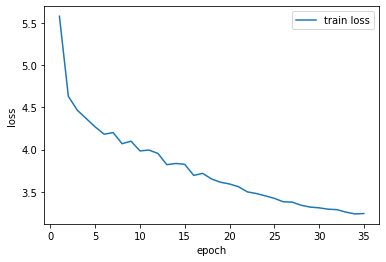

In [ ]:
#plotting loss
plt.figure()
XX=list(range(1,epochs+1))
plt.plot(XX,train_loss_pe)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss'])


Text(0.5, 1.0, "['<SOS>', 'a', 'dog', 'is', 'running', 'across', 'a', 'grassy', 'field', '<EOS>']")

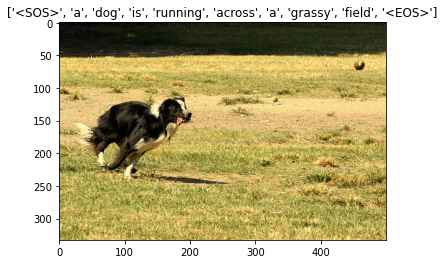

In [ ]:
plt.figure()

selected_pic_id=test_pics[1+5*305]

pict=Image.open(images_path+'/'+selected_pic_id)
pict=transform_method(pict)
pict=pict.to(device)

gen_capt=model.Generate_Caption(pict,dataset.MyVocab,cap_len=40)

im=image.imread(images_path+'/'+selected_pic_id)
plt.imshow(im)
plt.title(gen_capt)